In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [20]:
import pandas as pd
import os, shutil
import cv2
import skimage
import tensorflow as tf
import matplotlib.pyplot as plt

## Pre-Processing

In [21]:
# Define the directory containing the images
dir_path = '/kaggle/input/123-of-ai-presents-pneumonia-detection-from-xray/processed_train_data'

# List all files in the directory
img_files = os.listdir(dir_path)

df_metadata = pd.read_csv("/kaggle/input/123-of-ai-presents-pneumonia-detection-from-xray/1. train_metadata.csv")


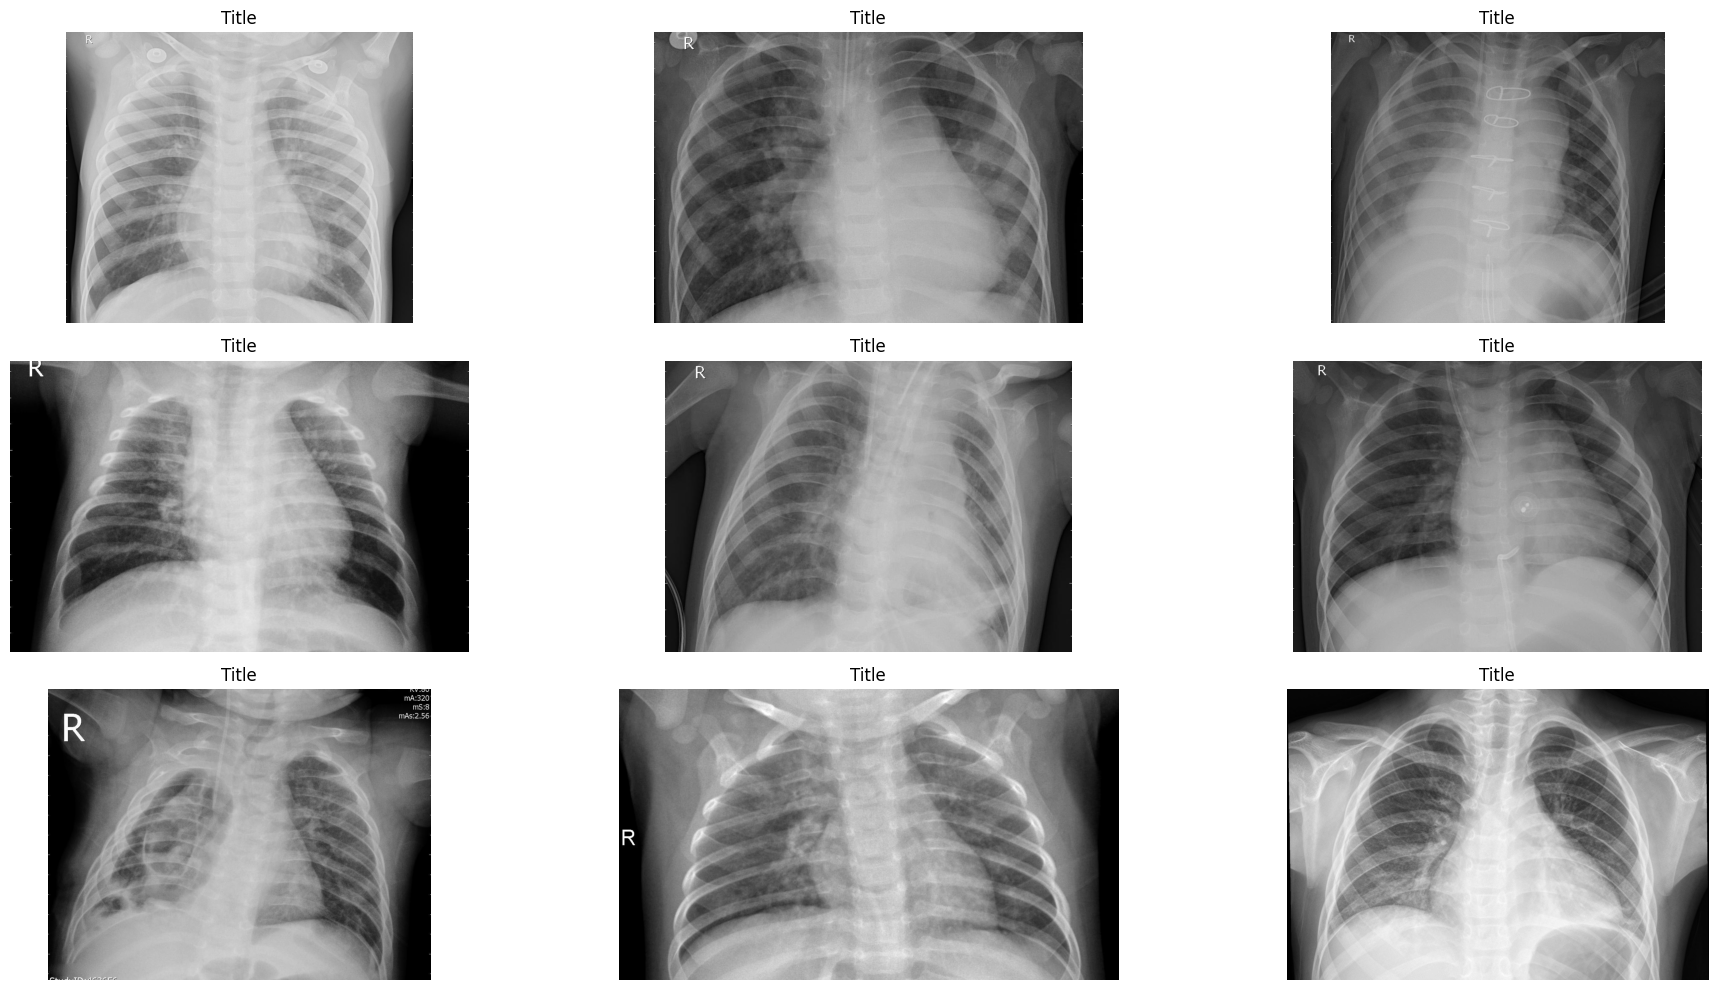

In [22]:
# 1. Displaying the data
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3,i+1)
    img_path = os.path.join(dir_path, img_files[i])
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Title")
plt.tight_layout()
plt.show()

# It is evident from the below images, they are in different sizes.

In [23]:
# 2. Explore distribution - understand the data
df_metadata.tail(5)
df_metadata.nunique()

# We have 2 classes present -> pneumonia and healthy

path     10429
class        2
dtype: int64

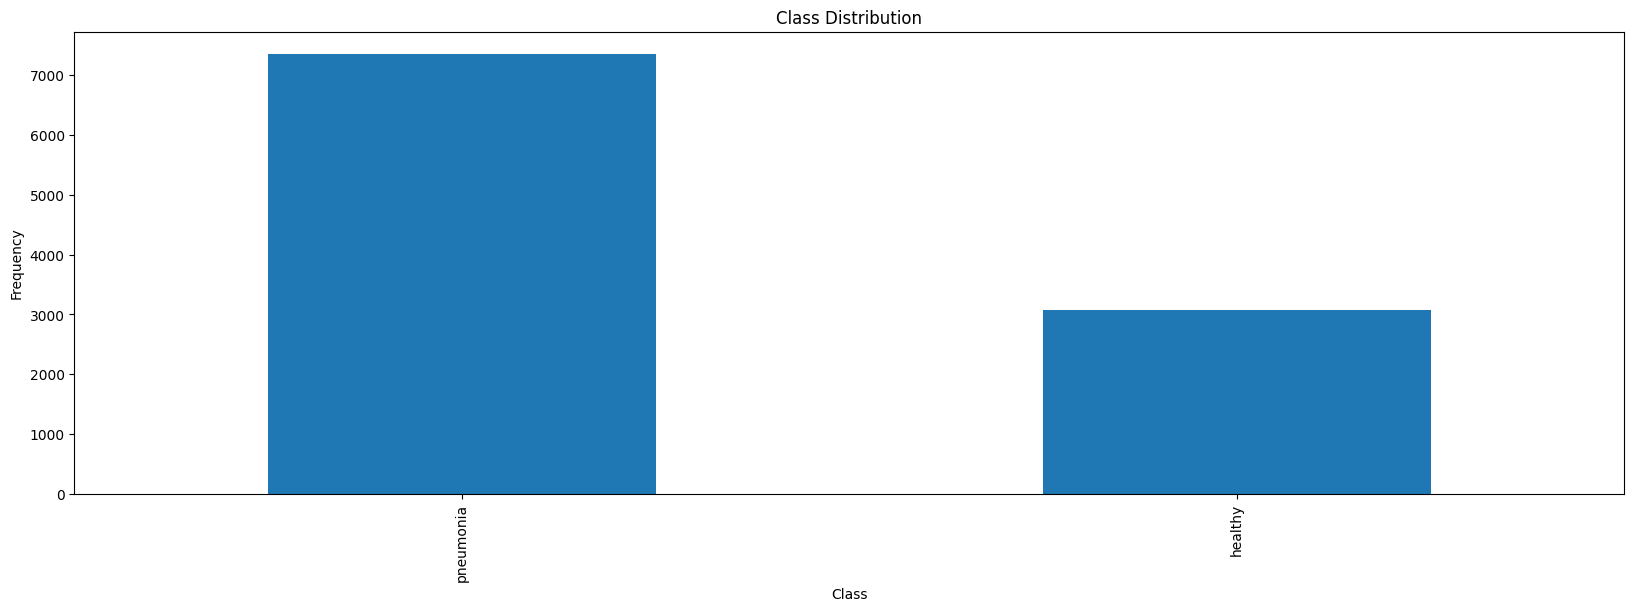

In [24]:
# 2a. Plot the class distribution
class_counts = df_metadata['class'].value_counts()
class_counts.plot(kind='bar', figsize=(20, 6))
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

#There is an imbalance in the dataset, we have more samples in pnemonia class than in healthy

In [25]:
# 3a. Pre-processing 
# Resizing, Color Space, Input construction (what to give as an input?)
# Helper Functions - If we make use of ImageDataGenerator and flow_from_directory, we have inbuilt capabilities

def resize_image(image, size=(224, 224)):
    return cv2.resize(image, size)

def normalize_image(image):
    return image / 255.0

def convert_color_space(image, color_space='gray'):
    if color_space == 'gray':
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif color_space == 'rgb':
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        raise ValueError("Unsupported color space")

def preprocess_images(image_paths, size=(224, 224), color_space='gray'):
    preprocessed_images = []
    for image_path in image_paths:
        image = preprocess_image(image_path, size, color_space)
        preprocessed_images.append(image)
    return np.array(preprocessed_images)


In [26]:
# Define the paths
# Create and copy healthy and pneumonia images to working dir in kaggle 
base_dir = '/kaggle/working/processed_train_data'
healthy_dir = os.path.join(base_dir, 'healthy')
pneumonia_dir = os.path.join(base_dir, 'pneumonia')

# Create directories if they don't exist
os.makedirs(healthy_dir, exist_ok=True)
os.makedirs(pneumonia_dir, exist_ok=True)

# Load the metadata file
metadata_file = '/kaggle/input/123-of-ai-presents-pneumonia-detection-from-xray/1. train_metadata.csv'
metadata = pd.read_csv(metadata_file)

# Source directory where images are currently stored
source_dir = '/kaggle/input/123-of-ai-presents-pneumonia-detection-from-xray/processed_train_data'

# Iterate through the metadata and move images
for index, row in metadata.iterrows():
    img_name = row['path']
    img_class = row['class']
    
    if img_class == 'healthy':
        shutil.copy(os.path.join(source_dir, img_name), os.path.join(healthy_dir, img_name))
    elif img_class == 'pneumonia':
        shutil.copy(os.path.join(source_dir, img_name), os.path.join(pneumonia_dir, img_name))

print("Images have been copied successfully!")


Images have been copied successfully!


In [27]:
# 3b. Synthetic Data Generation
# ImageDataGenerator helps in DataTransformation/Augmentation, Normalization/Scaling
# We can also make use of validation_split to generate train and validation sets
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,
    validation_split=0.2
)


In [38]:
# 3c. Data composition into tf format 
#  The method expects a specific directory structure where images are organized into subdirectories, 
#  each representing a class. This is an important note. Also subset='training/validation'

train_dir ='/kaggle/working/processed_train_data'

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to 224x224, Default is 256x256
    batch_size=32, #default is 32
    class_mode='binary', # Possible values are categorical, binary, sparse, input, None
#     color_mode='grayscale', # rgb, rgba, grayscale
    subset='training'
    
)


validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
#     color_mode='grayscale',
    subset='validation'
)

Found 8344 images belonging to 2 classes.
Found 2085 images belonging to 2 classes.


In [29]:
# Any other relevant pre-processing (upto your exploration)

## Model Development

In [30]:
# 1. Divide into train and test (can be done in the model.fit too)

In [39]:
# 2. Define Model 
# Define the CNN model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
# pip install tensorflow-addons

In [40]:
# 3. Define model compilation requirements - optimizer, loss, early stopping, etc. 

# We don't have any direct metric f1_score in tf.keras.metric, so need to get from add-on
#import tensorflow_addons as tfa
#f1_score = tfa.metrics.F1Score(num_classes=1, threshold=0.5)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [41]:
# 4. Enable tensorboard for tracking
from tensorflow.keras.callbacks import TensorBoard
import datetime
log_dir = "/kaggle/working/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_dir = "/kaggle/working/checkpoints"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_dir + "/model-{epoch:02d}-{val_loss:.2f}.keras",
    save_weights_only=False, #if True only weights will be saved, then it must be .h5 extn
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min',
    verbose=1
)

In [42]:
# 5. Fit Model; make sure to save checkpoints at intermediate points to avoid loss of information
### Experiment with different models and design

# Adding class weight to 
from sklearn.utils.class_weight import compute_class_weight
y_train = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    callbacks=[tensorboard_callback,checkpoint_callback,early_stopping_callback],
    class_weight=class_weight_dict
)



Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727077281.259928     198 service.cc:145] XLA service 0x7c6d94004e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727077281.260004     198 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727077281.260016     198 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1727077288.178155     198 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.6655 - loss: 0.7305

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.42120, saving model to /kaggle/working/checkpoints/model-01-0.42.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 241s 875ms/step - accuracy: 0.6657 - loss: 0.7298 - val_accuracy: 0.7832 - val_loss: 0.4212
Epoch 2/50
  1/260 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.8438 - loss: 0.3593

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.42120 to 0.23598, saving model to /kaggle/working/checkpoints/model-02-0.24.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8438 - loss: 0.3593 - val_accuracy: 0.8000 - val_loss: 0.2360
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.7950 - loss: 0.4307
Epoch 3: val_loss did not improve from 0.23598
260/260 ━━━━━━━━━━━━━━━━━━━━ 226s 850ms/step - accuracy: 0.7950 - loss: 0.4307 - val_accuracy: 0.7745 - val_loss: 0.4334
Epoch 4/50
  1/260 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.8438 - loss: 0.3058
Epoch 4: val_loss did not improve from 0.23598
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8438 - loss: 0.3058 - val_accuracy: 1.0000 - val_loss: 0.2522
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.8155 - loss: 0.3870
Epoch 5: val_loss did not improve from 0.23598
260/260 ━━━━━━━━━━━━━━━━━━━━ 225s 849ms/step - accuracy: 0.8155 - loss: 0.3870 - val_accuracy: 0.8486 - val_loss: 0.3506
E

In [43]:
# Seems like there is an issue with Kaggle while loading tensorboard
# Search for "kkb-production.jupyter-proxy.kaggle.net took too long to respond"
%reload_ext tensorboard
%tensorboard --logdir /kaggle/working/logs/fit/

In [45]:
# 6. Evaluate with relevant metric for your problem. 

# Evaluate the model on the validation data
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Test Loss: {loss}')
print(f'Validation Test Accuracy: {accuracy * 100:.2f}%')
#print(f'Validation Test F1 Score: {f1_score:.2f}')

66/66 ━━━━━━━━━━━━━━━━━━━━ 46s 690ms/step - accuracy: 0.8569 - loss: 0.3429
Validation Test Loss: 0.3449295163154602
Validation Test Accuracy: 85.76%


In [ ]:
# 7. After model choice is made, fine-tune model - hyperparameters!

## Trasnfer Learning using ResNet50

In [60]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # For binary classification

# Create the final model
model_tf = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_tf.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Data generators
#train_datagen = ImageDataGenerator(rescale=1./255)
#train_generator = train_datagen.flow_from_directory('/kaggle/working/processed_train_data', target_size=(224, 224), batch_size=32, class_mode='binary')

#validation_datagen = ImageDataGenerator(rescale=1./255)
#validation_generator = validation_datagen.flow_from_directory('/kaggle/working/processed_train_data', target_size=(224, 224), batch_size=32, class_mode='binary')

# Train the model
history_tf = model_tf.fit(train_generator, epochs=10, validation_data=validation_generator, class_weight=class_weight_dict, callbacks=[checkpoint_callback,early_stopping_callback])


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.5457 - loss: 0.7892
Epoch 1: val_loss did not improve from 0.23598
261/261 ━━━━━━━━━━━━━━━━━━━━ 231s 833ms/step - accuracy: 0.5459 - loss: 0.7888 - val_accuracy: 0.7966 - val_loss: 0.5103
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.7006 - loss: 0.5993
Epoch 2: val_loss did not improve from 0.23598
261/261 ━━━━━━━━━━━━━━━━━━━━ 216s 810ms/step - accuracy: 0.7006 - loss: 0.5993 - val_accuracy: 0.8149 - val_loss: 0.4834
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.7329 - loss: 0.5701
Epoch 3: val_loss did not improve from 0.23598
261/261 ━━━━━━━━━━━━━━━━━━━━ 218s 818ms/step - accuracy: 0.7329 - loss: 0.5701 - val_accuracy: 0.6988 - val_loss: 0.5993
Epoch 3: early stopping


In [61]:
from tensorflow.keras.optimizers import Adam

# Unfreeze some layers of the base model
for layer in base_model.layers[-5:]:  # Unfreeze the last 10 layers
    layer.trainable = True

# Compile the model with a lower learning rate
model_tf.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training the model with fine-tuning
history_fine = model_tf.fit(train_generator, epochs=10, validation_data=validation_generator,class_weight=class_weight_dict, callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.7506 - loss: 0.5241
Epoch 1: val_loss did not improve from 0.23598
261/261 ━━━━━━━━━━━━━━━━━━━━ 234s 839ms/step - accuracy: 0.7507 - loss: 0.5240 - val_accuracy: 0.6249 - val_loss: 0.6714
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.7963 - loss: 0.4439
Epoch 2: val_loss did not improve from 0.23598
261/261 ━━━━━━━━━━━━━━━━━━━━ 218s 815ms/step - accuracy: 0.7963 - loss: 0.4438 - val_accuracy: 0.8460 - val_loss: 0.3825
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.8160 - loss: 0.4127
Epoch 3: val_loss did not improve from 0.23598
261/261 ━━━━━━━━━━━━━━━━━━━━ 217s 812ms/step - accuracy: 0.8160 - loss: 0.4127 - val_accuracy: 0.8811 - val_loss: 0.3198
Epoch 3: early stopping


## Testing and Creating Output

In [46]:
import os
import shutil

# Create the directory structure - Prepare the test directory in kaggle/working
testdata = '/kaggle/working/testdata/images'
os.makedirs(testdata, exist_ok=True)

# Define source and destination directories
source_dir = '/kaggle/input/123-of-ai-presents-pneumonia-detection-from-xray/processed_test_set'
destination_dir = testdata

# Copy files from source to destination
for filename in os.listdir(source_dir):
    src_file = os.path.join(source_dir, filename)
    dst_file = os.path.join(destination_dir, filename)
    shutil.copy(src_file, dst_file)


In [62]:
# Creating output file for submission - Template Code
test_pd = pd.read_csv('/kaggle/input/123-of-ai-presents-pneumonia-detection-from-xray/2. test_files.csv')

# Do the same pre-processing/formatting as the training set for the test set - remember to use batch_size 1 for testing
test_data_dir = '/kaggle/working/testdata/'
test_datagen = ImageDataGenerator(rescale=1./255) #No augmentation needed for test :)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=1,      # Process one by one
    class_mode=None,   # No labels for test data, so None
    shuffle=False      # Preserve the order for test
)

if test_generator.samples == 0:
    raise ValueError("The test_generator is empty. Please check the directory structure and paths.")

# Evaluate trained model on test set - Load your trained model
#model = tf.keras.models.load_model('/kaggle/working/checkpoints/model-02-0.24.keras')
#predictions = model.predict(test_generator)
#y_pred = np.where(predictions > 0.5, 1, 0).flatten()

# Evaluate on TF+FineTuned model
predictions = model_tf.predict(test_generator)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()


# Save results to CSV
submission = pd.DataFrame({'ID': test_pd.index, 'class' : ['pneumonia' if pred == 1 else 'healthy' for pred in y_pred]})
submission.to_csv('output_submission_eval.csv', index=False)

Found 1928 images belonging to 1 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1928/1928 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step


In [38]:
# If you would like to save the model from working dir to your local machine
model.save('/kaggle/working/checkpoints/model-14-0.07.keras')
!zip -r /kaggle/working/model-14-0.07.zip /kaggle/working/checkpoints/model-14-0.07.keras

  adding: kaggle/working/checkpoints/model-14-0.07.keras (deflated 26%)
